In [1]:
import numpy as np
import pandas as pd
from oemof import solph
from dash import html, dcc, Dash
import plotly.graph_objects as go

try:
    from oemof_visio import ESGraphRenderer

    ES_GRAPH = True
except ModuleNotFoundError:
    ES_GRAPH = False

from main import generate_blackout_events, compute_blackout_kpis

average_frequency = 45
std_frequency = 0.1
average_duration = 3
std_duration = 0.1

evaluated_days = 3
date_time_index = pd.date_range(
    start="2024-01-01", freq="h", periods=evaluated_days * 24
)

# Variante 1 model grid availability using the `max` attribute of the Source/Sink of the DSO

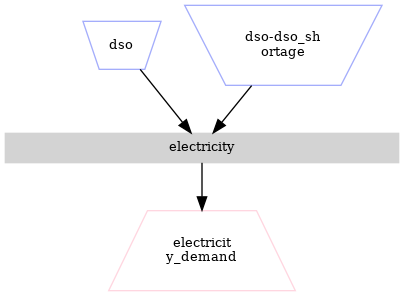

Accumulated blackout duration: 12.402
Accumulated blackout duration (rounded to timestep): 12.0
1 3
Due to 1 overlapping blackouts, the total random blackout duration (12.0) is not equal with the real grid unavailability (11).
Grid is not operational for 11 hours out of 72, with a reliability of 84.72 percent. 

blackout_example.png


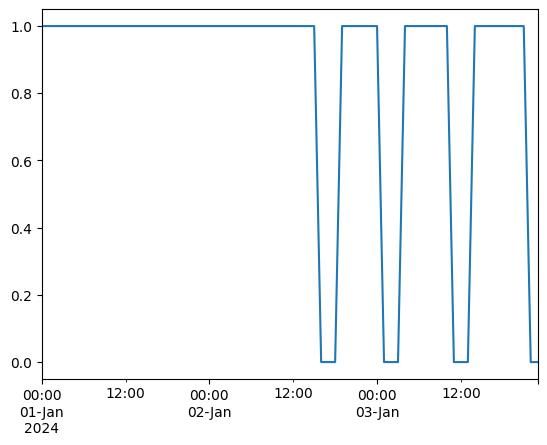

In [2]:
grid_availability, blackout_events_duration, overlapping_blackouts, blackout_count = (
    generate_blackout_events(average_frequency, average_duration, date_time_index)
)
print(overlapping_blackouts, blackout_count)

compute_blackout_kpis(
    grid_availability, blackout_events_duration, overlapping_blackouts, blackout_count
)


ga = grid_availability

load = pd.Series(10, index=date_time_index)


energy_system = solph.EnergySystem(timeindex=date_time_index, infer_last_interval=False)


b_el = solph.Bus(label="electricity")

dso = solph.components.Source(
    label="dso",
    outputs={
        b_el: solph.Flow(
            nominal_value=solph.Investment(ep_costs=0),
            max=ga.values,
            variable_costs=0.1,
        )
    },
)

dso_shortage = solph.components.Source(
    label="dso-dso_shortage",
    outputs={b_el: solph.Flow(variable_costs=1)},
)

demand_el = solph.components.Sink(
    label="electricity_demand",
    inputs={b_el: solph.Flow(fix=load.values, nominal_value=1)},
)

energy_system.add(
    b_el,
    dso,
    dso_shortage,
    demand_el,
)

# but the less accurate the results would be.
solver_option = {"gurobi": {"MipGap": "0.02"}, "cbc": {"ratioGap": "0.02"}}
solver = "cbc"

if ES_GRAPH is True:
    gr = ESGraphRenderer(energy_system, filepath="blackout_example", img_format="png")
    gr.render()

model = solph.Model(energy_system)

In [3]:
model.solve(
    solver=solver,
    solve_kwargs={"tee": True},
    cmdline_options=solver_option[solver],
)

results = solph.processing.convert_keys_to_strings(solph.processing.results(model))

fig_dict = gr.sankey(results)


bus_figures = []


for nd in energy_system.nodes:
    if isinstance(nd, solph.Bus):
        bus = nd.label
        fig = go.Figure(layout=dict(title=f"{bus} bus node"))
        for t, g in solph.views.node(results, node=bus)["sequences"].items():
            idx_asset = abs(t[0].index(bus) - 1)

            fig.add_trace(
                go.Scatter(
                    x=g.index, y=g.values * pow(-1, idx_asset), name=t[0][idx_asset]
                )
            )

    bus_figures.append(fig)


fig = go.Figure(data=fig_dict)

app = Dash(__name__)
app.title = "Blackouts example"
app.layout = html.Div(
    [dcc.Graph(figure=fig)]
    + [
        dcc.Graph(
            figure=fig,
        )
        for fig in bus_figures
    ]
)

app.run_server(debug=False, port=8070)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Mar 24 2020 

command line - /usr/bin/cbc -ratioGap 0.02 -printingOptions all -import /tmp/tmpu5ksca6x.pyomo.lp -stat=1 -solve -solu /tmp/tmpu5ksca6x.pyomo.soln (default strategy 1)
ratioGap was changed from 0 to 0.02
Option for printingOptions changed from normal to all
Presolve 0 (-143) rows, 0 (-144) columns and 0 (-276) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 21873 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve 0